YELP (tip.parquet)

In [1]:
#Iniciamos nuestro proyecto desarrollando un Análisis y Depuración de Datos.
import findspark
findspark.init()
import pyspark
findspark.find()
import os 

In [2]:
from functools import reduce
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [3]:
spark

In [4]:
#Importamos la biblioteca para Koalas
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
collections.Callable = collections.abc.Callable

import databricks.koalas as ks

In [5]:
spark = SparkSession.builder.appName("YelpEDA").getOrCreate()

#Cargando el archivo con Tip.parquet usando Spark
tip_spark_df = spark.read.parquet(r"C:\Users\Pierinna\Desktop\DataSets_GoogleMaps\PG_Google_Yelp\Proyecto_Final\Yelp_\tip.parquet")

In [6]:
#Convertir Spark DataFrame a Koalas DataFrame:
tip_koalas_df = ks.DataFrame(tip_spark_df)

In [7]:
#Muestra las primeras filas del DataFrame:
print(tip_koalas_df.head())

                  user_id             business_id                                                       text                 date  compliment_count
0  AGNUgVwnZUey3gcPCJ76iw  3uLgwr0qeCNMjKenHJwPGQ                             Avengers time with the ladies.  2012-05-18 02:17:21                 0
1  NBN4MgHP9D3cw--SnauTkA  QoezRbYQncpRqyrLH6Iqjg  They have lots of good deserts and tasty cuban sandwiches  2013-02-05 18:35:10                 0
2  -copOvldyKh1qr-vzkDEvw  MYoRNLb5chwjQe3c_k37Gg                     It's open even when you think it isn't  2013-08-18 00:56:08                 0
3  FjMQVZjSqY8syIO-53KFKw  hV-bABTK-glh5wj31ps_Jw                                  Very decent fried chicken  2017-06-27 23:05:38                 0
4  ld0AperBXk1h6UbqmM80zw  _uN0OudeJ3Zl_tf6nxg5ww                     Appetizers.. platter special for lunch  2012-10-06 19:43:09                 0


In [15]:
#tip_koalas_df

In [9]:
#muestra la cantidad de filas y columnas
print("Numero de filas:", len(tip_koalas_df))
print("Numero de columnas:", len(tip_koalas_df.columns))

Numero de filas: 908915
Numero de columnas: 5


In [10]:
#vemos los tipos de datos de las columnas:
print("Tipos de datos:")
print(tip_koalas_df.dtypes)

Tipos de datos:
user_id             object
business_id         object
text                object
date                object
compliment_count     int64
dtype: object


In [11]:
#podemos ver la cantidad de valores nullos por columna:
print("Valores nulos por columna")
print(tip_koalas_df.isnull().sum())

Valores nulos por columna


user_id             0
business_id         0
text                0
date                0
compliment_count    0
Name: 0, dtype: int64


DATOS ANALITICOS PARA SPARK:

- Dado que la cantidad de datos que tenemos son aproximadamente 1 Millon de estos, procedemos a utilizar Spark y Koalas como medio para observar de manera detallada los datos y poder pasar a un analisis general de cada uno de estos.

In [12]:
#Imprimimos las estadisticas descriptivas:
tip_spark_df.describe().show()

+-------+--------------------+--------------------+--------------------+-------------------+--------------------+
|summary|             user_id|         business_id|                text|               date|    compliment_count|
+-------+--------------------+--------------------+--------------------+-------------------+--------------------+
|  count|              908915|              908915|              908915|             908915|              908915|
|   mean|                null|                null|1.792114762548089...|               null|0.012524823553357574|
| stddev|                null|                null|1.411112521356809...|               null| 0.12076339327984201|
|    min|---r61b7EpVPkb4UV...|---kPU91CF4Lq2-Wl...|                   !|2009-04-16 13:11:49|                   0|
|    max|zzxZW6U5lCCQQeVfL...|zzyx5x0Z7xXWWvWnZ...|to the apple gor...|2022-01-19 20:38:55|                   6|
+-------+--------------------+--------------------+--------------------+----------------

- Planteamos que las columnas Business_id y user_id sean unicos y no contengan datos incosistentes.
- Se planteo analizar el texto de las reseñas, podría ser útil aplicar técnicas de procesamiento de lenguaje natural (NLP) para tokenizar, limpiar y analizar el contenido de las reseñas.
- Se planteo analizar las fechas, podrías extraer información adicional como el día de la semana o el mes para obtener patrones estacionales.
- Se planteo analizar y manejar los valores atípicos en la columna compliment_count utilizando los pasos que mencioné anteriormente.

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql import functions as F

#Crear la sesión de Spark
spark = SparkSession.builder.appName("YelpAnalysis").getOrCreate()

#Cargar los datos en el DataFrame
tip_spark_df = spark.read.parquet(r"C:\Users\Pierinna\Desktop\DataSets_GoogleMaps\PG_Google_Yelp\Proyecto_Final\Yelp_\tip.parquet")

#Verificar columnas de IDs
user_id_counts = tip_spark_df.select("user_id").distinct().count()
business_id_counts = tip_spark_df.select("business_id").distinct().count()
print(f"Total de user_ids únicos: {user_id_counts}")
print(f"Total de business_ids únicos: {business_id_counts}")

#Procesamiento de texto (NLP)
#Aquí se pueden aplicar técnicas de procesamiento de lenguaje natural al contenido de las reseñas en la columna 'text':

#Procesamiento de fechas
tip_spark_df = tip_spark_df.withColumn("date", col("date").cast("timestamp"))
tip_spark_df = tip_spark_df.withColumn("day_of_week", F.dayofweek("date"))
tip_spark_df = tip_spark_df.withColumn("month", F.month("date"))

#Valores atípicos en 'compliment_count'
Q1 = tip_spark_df.approxQuantile("compliment_count", [0.25], 0.05)[0]
Q3 = tip_spark_df.approxQuantile("compliment_count", [0.75], 0.05)[0]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = tip_spark_df.filter((col("compliment_count") < lower_bound) | (col("compliment_count") > upper_bound))
print("Valores atípicos en 'compliment_count':")
outliers.select("user_id", "business_id", "text", "compliment_count").show(truncate=False)

#Cerrar la sesión de Spark
spark.stop()


Total de user_ids únicos: 301758
Total de business_ids únicos: 106193
Valores atípicos en 'compliment_count':
+----------------------+----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+
|user_id               |business_id           |text                                                                                                                                                                                                                                                                                                 |compliment_count|
+----------------------+----------------------+-----------------------------------------------------------------------------------------------------------------------------

DATOS ANALITICOS EN KOALA:

- Dado que el DataFrame elaborado en Koala no nos lanzaba datos Null (como pueden observar en las graficas de arriba), decidimos realizar un histograma:

- La gráfica mostrará cómo se distribuyen los valores de 'compliment_count' en las reseñas.

- Si las barras están concentradas hacia la izquierda, significa que la mayoría de las reseñas tienen valores bajos de 'compliment_count'.

- Si las barras se extienden hacia la derecha, indica que algunas reseñas tienen valores más altos de 'compliment_count'.

La altura de las barras representa la cantidad de reseñas que tienen el número de cumplidos correspondiente.


In [14]:
#Explora la distribución de los valores en la columna 'user_id'
print(tip_koalas_df['user_id'].value_counts())

RuntimeError: SparkContext or SparkSession should be created first.

In [ ]:
print(tip_koalas_df['business_id'].value_counts())

FEXhWNCMkv22qG04E83Qjg    2571
-QI8Qi8XWH3D8y8ethnajA    1011
_ab50qdWOk0DdB6XOrBitw     932
ytynqOUb3hjKeJfRj5Tshw     827
Eb1XmmLWyt_way5NNZ7-Pw     826
c_4c5rJECZSfNgFj7frwHQ     750
ac1AeYqs8Z4_e2X5M3if2A     613
GBTPC53ZrG1ZBY3DT8Mbcw     608
iSRTaT9WngzB8JJ2YKJUig     606
GXFMD0Z4jEVZBCsbPf4CTQ     579
I_3LMZ_1m2mzR0oLIOePIg     577
8O35ji_yOMVJmZ6bl96yhQ     561
QHWYlmVbLC3K6eglWoHVvA     551
oBNrLz4EDhiscSlbOl8uAw     541
gTC8IQ_i8zXytWSly3Ttvg     532
yPSejq3_erxo9zdVYTBnZA     526
4i4kmYm9wgSNyF1b6gKphg     521
VQcCL9PiNL_wkGf-uF3fjg     512
RQAF6a0akMiot5lZZnMNNw     460
VaO-VW3e1kARkU9bP1E7Fw     441
6a4gLLFSgr-Q6CZXDLzBGQ     439
6Ty-KKWq6hLZYW8DWEHYvg     426
QTbahs-GVuWYL5yfdjH34A     424
wz8ZPfySQczcPgSyd33-HQ     414
_C7QiQQc47AOEv4PE3Kong     406
PP3BBaVxZLcJU54uP_wL6Q     400
EagkHaaC-kUozD3MPzbRIw     389
J0joPXxmN-_9Lzafspqdbw     387
DcBLYSvOuWcNReolRVr12A     384
AGlh4ZDv6jnoiYfz7At9mw     382
1b5mnK8bMnnju_cvU65GqQ     380
VVH6k9-ycttH3TV_lk5WfQ     375
qclZoDz3

In [ ]:
print(tip_koalas_df['compliment_count'].value_counts())

0    898376
1      9821
2       617
3        82
4        14
5         3
6         2
Name: compliment_count, dtype: int64


In [ ]:
#Cantidad de valores únicos en la columna 'user_id'
print("Cantidad de usuarios únicos:", tip_koalas_df['user_id'].nunique())

Cantidad de usuarios únicos: 301758


In [ ]:
#Cantidad de negocios únicos en la columna 'business_id'
print("Cantidad de negocios únicos:", tip_koalas_df['business_id'].nunique())

Cantidad de negocios únicos: 106193


VISUALIZACION DE GRAFICOS

In [ ]:
import matplotlib.pyplot as plt

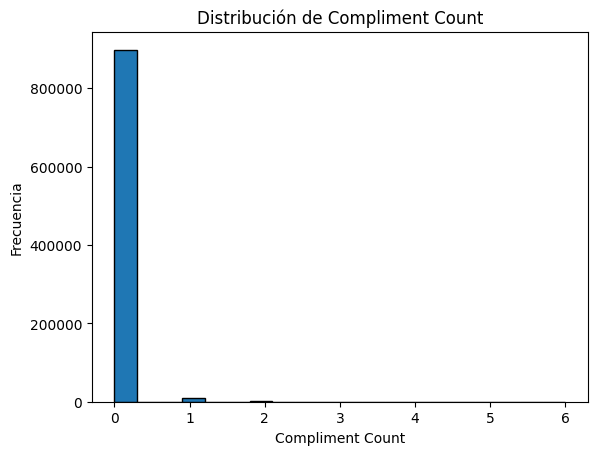

In [ ]:
#Histograma de 'compliment_count'
plt.hist(tip_koalas_df['compliment_count'], bins=20, edgecolor='k')
plt.xlabel('Compliment Count')
plt.ylabel('Frecuencia')
plt.title('Distribución de Compliment Count')
plt.show()